## 기본 세팅

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install imagehash > /dev/null

In [3]:
filepath = '/content/drive/MyDrive/Project II/pet_data/'
train_path = filepath + 'train/'
cat_path = train_path + 'cat/'
dog_path = train_path + 'dog/'

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from glob import glob
import sys
import cv2
import imageio
import joblib
import math
import warnings
import os
import torch
import imagehash
import matplotlib.patches as patches

## YOLOv5를 사용해서 동물 객체의 범위 받아오기?

 - 아래 내용은 [캐글 참고](https://www.kaggle.com/markwijkhuizen/petfinder-eda-yolov5-obj-detection-tfrecords)
 에서 가져왔음

In [5]:
# Download YOLOV5 GitHub Repo
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 9876, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 9876 (delta 93), reused 134 (delta 89), pack-reused 9734
Receiving objects: 100% (9876/9876), 10.05 MiB | 24.10 MiB/s, done.
Resolving deltas: 100% (6871/6871), done.


In [6]:
# Load Best Performing YOLOV5X Model
yolov5x6_model = torch.hub.load('ultralytics/yolov5', 'yolov5x6')

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip


requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...


YOLOv5 🚀 2021-10-22 torch 1.9.0+cu111 CUDA:0 (Tesla K80, 11441.1875MB)



  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13

requirements: 1 package updated per /root/.cache/torch/hub/ultralytics_yolov5_master/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect



  0%|          | 0.00/269M [00:00<?, ?B/s]

Fusing layers... 
Model Summary: 574 layers, 140730220 parameters, 0 gradients
Adding AutoShape... 


- 이미지 분석 함수 YOLOv5를 사용하고 있고 캐글에서 만든 함수를 수정하여 사용중

In [7]:
%matplotlib inline 

In [11]:
# Get Image Info
def get_image_info(file_path, plot=False):
    # Read Image
    image = imageio.imread(file_path)
    h, w, c = image.shape
    
    # 그래프
    if plot: # Debug Plots
        fig, ax = plt.subplots(1, 2, figsize=(8,8))
        ax[0].set_title('Pets detected in Image', size=16)
        ax[0].imshow(image)
        
    # Get YOLOV5 results using Test Time Augmentation for better result
    results = yolov5x6_model(image, augment=True)
    
    # Mask for pixels containing pets, initially all set to zero
    pet_pixels = np.zeros(shape=[h, w], dtype=np.uint8)
    
    # Dictionary to Save Image Info
    h, w, _ = image.shape # 높이, 너비, 차원
    image_info = { 
        'n_pets': 0, # Number of pets in the image
        'labels': [], # Label assigned to found objects 
        'person' : 0, # 사람의 신체부위나 사람이 나타나는 경우
        'thresholds': [], # confidence score
        'coords': [], # coordinates of bounding boxes
        'x_min': 0, # minimum x coordinate of pet bounding box
        'x_max': w - 1, # maximum x coordinate of pet bounding box
        'y_min': 0, # minimum y coordinate of pet bounding box
        'y_max': h - 1, # maximum x coordinate of pet bounding box
    }
    
    # Save found pets to draw bounding boxes
    pets_found = []
    
    # Save info for each pet
    for x1, y1, x2, y2, treshold, label in results.xyxy[0].cpu().detach().numpy():
        label = results.names[int(label)]
        # print(f'label : {label}')
        
        # image_info 저장
        if label in ['cat', 'dog']:
          image_info['n_pets'] += 1
          # Set pixels containing pets to 1
          pet_pixels[int(y1):int(y2), int(x1):int(x2)] = 1 # label이 cat, dog인 경우만 pet의 범위로 지정

        if label in ['person']: # 사람의 신체부위가 나타나는 경우
          image_info['person'] += 1

        image_info['labels'].append(label)
        image_info['thresholds'].append(treshold)
        image_info['coords'].append(tuple([x1, y1, x2, y2]))
        image_info['x_min'] = max(x1, image_info['x_min'])
        image_info['x_max'] = min(x2, image_info['x_max'])
        image_info['y_min'] = max(y1, image_info['y_min'])
        image_info['y_max'] = min(y2, image_info['y_max'])
            

        # Add found pet
        pets_found.append([x1, x2, y1, y2, label])

    # 그래프
    if plot:
        for x1, x2, y1, y2, label in pets_found:
            c = 'red' if label == 'dog' else 'blue'
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor=c, facecolor='none')
            # Add the patch to the Axes
            ax[0].add_patch(rect)
            ax[0].text(max(25, (x2+x1)/2), max(25, y1-h*0.02), label, c=c, ha='center', size=14)
                
    # Add Pet Ratio in Image
    print(f'pet_ratio : {pet_pixels.sum() / (h*w)}')
    image_info['pet_ratio'] = pet_pixels.sum() / (h*w)

    if plot:
        # Show pet pixels
        ax[1].set_title('Pixels Containing Pets', size=16)
        ax[1].imshow(pet_pixels)
        plt.show()
        
    return image_info

## 코드 테스팅

In [13]:
# Read Image
img_path = filepath + 'acc_cat.jpg'
img = imageio.imread(img_path)
h, w, c = img.shape
h, w, c

(720, 1280, 3)

pet_ratio : 0.7473350694444445


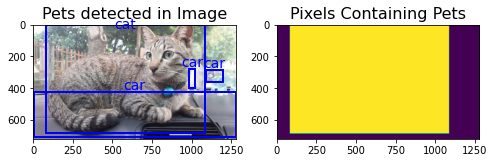

In [14]:
info = get_image_info(img_path, plot=True)

### get_most_color 함수
- 가장 많이 등장하는 rgb 색상을 상위 10개까지 찾아서 그려주는 함수

In [15]:
def get_most_color(info, img, plot=True):
  pos = [] # tuple x1, y1, x2, y2 좌표값

  for idx, label in enumerate(info['labels']):
    if label in ['cat', 'dog']:
      pos.append(info['coords'][idx])
  
  pet_pos = []

  for i in range(len(pos)):
    x1, y1, x2, y2 = pos[i]
    pet_pos.append(img[int(x1) : int(x2), int(y1) : int(y2)]) #labels 에서 cat이 있는 부분만 떼어서 새 배열에 저장
    
  # dictionary 구조를 이용해서 같은값이 가장 많이 나온 rgb 값을 찾을 예정
  rgb_list = {} 

  for pp in pet_pos: # 모든 펫의 이미지 범위에 대해
    for f in pp: # 펫 별로
      for rgb in f: # 1픽셀의 rgb 값
        # [255, 255, 255] 를 '255 255 255' 형식으로 전환
        rgb = " ".join(map(str, rgb))

        # 현재 dict에 존재하는지 판단해서 추가
        if rgb in rgb_list.keys():
          rgb_list[rgb] += 1
        else:
          rgb_list[rgb] = 1

  # dict value값으로 내림차순한 리스트 반환
  reverse_sort_rgb = sorted(rgb_list, key= lambda x : rgb_list[x], reverse=True)

  # 상위 rgb값을 받아올 예정
  top_rgb = []

  for color in reverse_sort_rgb[:10]:
    # '255 255 255'를 ['255', '255', '255']로 변환
    temp = color.split(' ')

    # 각 원소에 대해 문자열을 int 값으로 치환
    temp = [int(x) for x in temp]
    top_rgb.append(temp)
    
  # 3차원 rgb로 변환
  np_rgb = np.array(top_rgb)
  np_rgb = np.reshape(np_rgb, (1, -1, 3))

  if plot:
    plt.imshow(np_rgb)
    plt.show()
  
  return np_rgb

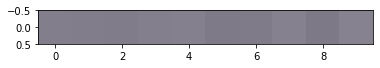

array([[[130, 126, 140],
        [129, 125, 139],
        [128, 124, 138],
        [131, 127, 141],
        [132, 128, 142],
        [126, 122, 136],
        [127, 123, 137],
        [133, 129, 143],
        [125, 121, 135],
        [134, 130, 144]]])

In [16]:
get_most_color(info, img)

### 강아지사진으로 테스트

In [17]:
# 강아지만 테스트
train = pd.read_csv(filepath + 'n_dog.csv')
train.head()

,Id,Subject Focus,Eyes,Face,Near,...,Human,Occlusion,Info,Blur,Pawpularity
0,dog0,0,1,1,1,...,0,0,0,0,63
1,dog1,0,1,1,1,...,1,1,0,0,28
2,dog2,0,1,1,1,...,0,0,0,0,15
3,dog3,0,0,1,0,...,0,0,0,1,74
4,dog4,0,1,1,1,...,1,1,0,0,22


pet_ratio : 0.6575615560119362


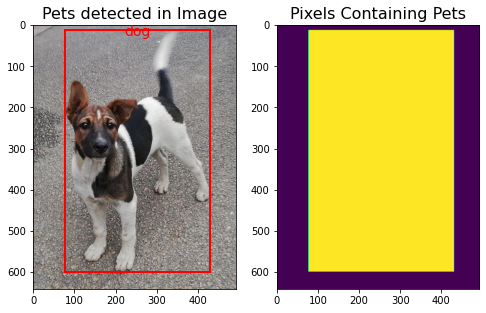

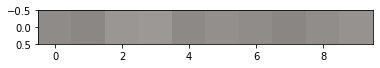

[[[143 139 136]
  [139 135 132]
  [154 150 147]
  [156 152 149]
  [141 137 134]
  [147 143 140]
  [144 140 137]
  [138 134 131]
  [145 141 138]
  [150 146 143]]]
pet_ratio : 0.2721046470199013


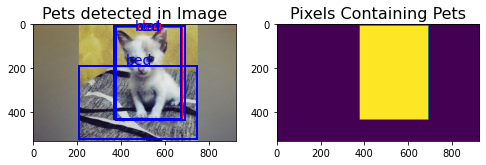

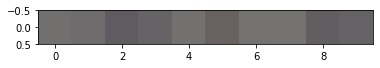

[[[113 112 110]
  [110 108 109]
  [ 96  91  97]
  [101  99 102]
  [114 113 111]
  [103  98  95]
  [115 114 112]
  [116 115 113]
  [ 98  93  97]
  [100  98 101]]]
pet_ratio : 0.3602126736111111


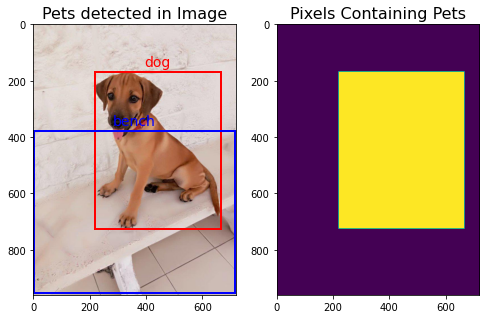

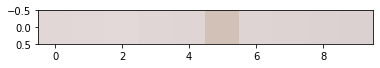

[[[225 215 214]
  [226 216 215]
  [227 217 216]
  [224 214 213]
  [223 213 212]
  [210 193 183]
  [222 212 211]
  [221 211 210]
  [220 210 209]
  [219 209 208]]]
pet_ratio : 0.4125


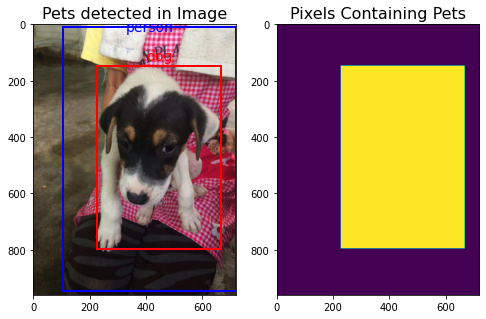

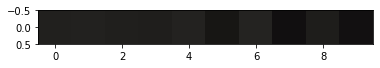

[[[33 32 30]
  [34 33 31]
  [32 31 29]
  [31 30 28]
  [35 34 32]
  [23 22 20]
  [36 35 33]
  [17 15 16]
  [30 29 27]
  [18 16 17]]]
pet_ratio : 0.3592824074074074


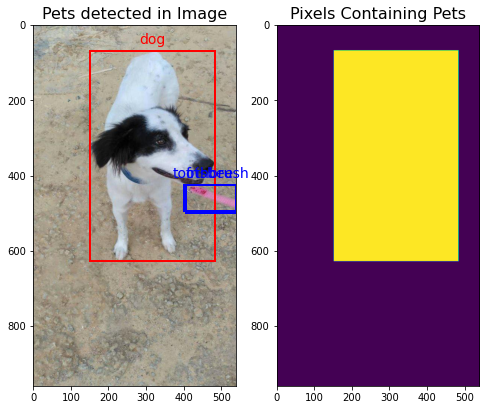

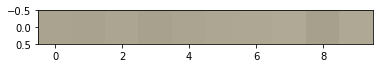

[[[170 163 144]
  [169 162 143]
  [172 165 146]
  [168 161 142]
  [171 164 145]
  [173 166 147]
  [174 167 148]
  [176 169 150]
  [167 160 141]
  [175 168 149]]]


In [22]:
for file_path in train['Id'].tail(5):
  img_path = dog_path + file_path + '.jpg'
  img = imageio.imread(img_path)
  info = get_image_info(img_path, plot=True)
  print(get_most_color(info, img)) # 상위 10개의 색상을 그리고 싶지 않을 경우 함수 마지막부분에 plot=False를 추가해야함